# Recommend songs based on spectrogram using pretrained embedding

### Import stuff

In [1]:
import os
import csv
import gensim
from gensim.models.callbacks import CallbackAny2Vec
import zipfile

try: # are we running on Google colab?
    # Load the Drive helper and mount
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False
#     os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#     os.environ["CUDA_VISIBLE_DEVICES"]="1"; ##########################################

if IN_COLAB:
    # This will prompt for authorization.
    drive.mount('/content/drive')

csv.field_size_limit(1000000); # for really long playlists!

C:\Users\tetic\Anaconda3\envs\Deep\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\tetic\Anaconda3\envs\Deep\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load in track data

In [2]:
if IN_COLAB and not os.path.exists('/tmp/spectrograms/'):
    print('Unzipping spectrograms...')
    zip_ref = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/spectrograms.zip', 'r')
    zip_ref.extractall('/tmp/')
    zip_ref.close()
    os.chdir('/tmp/')

if IN_COLAB:
    spectrograms_dir = '/tmp/spectrograms/'
    checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/'
else:
    spectrograms_dir = './spectrograms/'
    checkpoint_dir = './'
    
print('Read in tracks...')
tracks = {}
with open(checkpoint_dir + 'tracks.csv', "r", encoding='utf-8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    for row in spamreader:
        columns = str(row)[2:-2].split(';')
        tracks[columns[0]] = [columns[1] + ' - ' +
                              columns[2], columns[3]] # title - artist, url
print(f'Number of tracks: {len(tracks)}')

Read in tracks...
Number of tracks: 3981436


### Load in track embedding

In [3]:
class logger(CallbackAny2Vec):
    None
    
embedding_model = gensim.models.Word2Vec.load(checkpoint_dir + 'word2vec.model')
print(embedding_model)

Word2Vec(vocab=452130, size=100, alpha=0.025)


Populating the interactive namespace from numpy and matplotlib


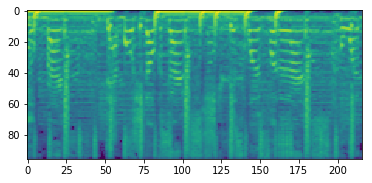

In [4]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(spectrograms_dir + 'train/000JCyEkMFumqCZQJAORiQ.png')
imgplot = plt.imshow(img)
plt.show()

In [5]:
time_steps = img.shape[1]
frequency_bands = img.shape[0]

In [6]:
embedding_norm = embedding_model.wv.syn0 #.copy()
#for i, vector in enumerate(embedding_norm):
#    norm = np.linalg.norm(embedding_norm[i], 2)
#    if norm != 0:
#        embedding_norm[i, :] = embedding_norm[i, :] / norm

C:\Users\tetic\Anaconda3\envs\Deep\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU,\
        SeparableConv1D, Convolution1D, MaxPooling1D, BatchNormalization, Flatten

input_shape = (frequency_bands, time_steps)
model_input = Input(input_shape, name='input')
layer = model_input

layer = SeparableConv1D(filters=96, kernel_size=7, data_format="channels_first", padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization(axis=1)(layer)
layer = MaxPooling1D(2, data_format="channels_first")(layer)
layer = Dropout(rate=0.2)(layer)

layer = SeparableConv1D(filters=96*2, kernel_size=7, data_format="channels_first", padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization(axis=1)(layer)
layer = MaxPooling1D(2, data_format="channels_first")(layer)
layer = Dropout(rate=0.3)(layer)

layer = SeparableConv1D(filters=96*4, kernel_size=7, data_format="channels_first", padding="same")(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization(axis=1)(layer)
layer = MaxPooling1D(2, data_format="channels_first")(layer)
layer = Dropout(rate=0.4)(layer)

layer = Flatten()(layer)
layer = Dense(1024)(layer)
layer = LeakyReLU(0.2)(layer)
layer = BatchNormalization(axis=1)(layer)
layer = Dropout(rate=0.5)(layer)

layer = Dense(embedding_norm.shape[1])(layer)
model_output = layer
model = Model(model_input, model_output)
model.compile(loss="cosine_proximity", optimizer="adam")
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 96, 216)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 96, 216)           9984      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 216)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 216)           384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 96, 108)           0         
_________________________________________________________________
dropout_1 (Dropout)  

In [8]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
    
def test_model(display_spectrograms = False):
    # guess some similar tracks
    for file in os.listdir(spectrograms_dir + 'test/'):
        track = file[0:-4]
        spectrogram = mpimg.imread(spectrograms_dir + 'test/' + file)
        if display_spectrograms:
            imgplot = plt.imshow(spectrogram)
            plt.show()
        x = expand_dims(spectrogram, axis=0)
        y_pred = model.predict(x)
        y_true = expand_dims(embedding_norm[embedding_model.wv.vocab[track].index], axis=0)
        loss = model.test_on_batch(x, y_true)
        print(f'Tracks most similar to {tracks[track][0]} [{-loss:.2f}] : {tracks[track][1]}')
        most_similar = embedding_model.wv.similar_by_vector(np.squeeze(y_pred, axis=0), topn=3)
        for similar in most_similar:
            if display_spectrograms:
                if os.path.exists(spectrograms_dir + 'train/' + similar[0] + '.png'):
                    spectrogram = mpimg.imread(spectrograms_dir + 'train/' + similar[0] + '.png')
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
                if os.path.exists(spectrograms_dir + 'val/' + similar[0] + '.png'):
                    spectrogram = mpimg.imread(spectrograms_dir + 'val/' + similar[0] + '.png')
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
            print(f'{similar[0]} : {tracks[similar[0]][0]} [{embedding_model.wv.similarity(track, similar[0]):.2f}] : {tracks[similar[0]][1]}')
        print()

def test_model2(display_spectrograms = False):
    # measure cos distance of most and least similar tracks
    for file in os.listdir(spectrograms_dir + 'test/'):
        track = file[0:-4]
        spectrogram = mpimg.imread(spectrograms_dir + 'test/' + file)
        if display_spectrograms:
            imgplot = plt.imshow(spectrogram)
            plt.show()
        x = expand_dims(spectrogram, axis=0)
        y_pred = model.predict(x)
        print(f'Tracks most similar to {tracks[track][0]} : {tracks[track][1]}')
        most_similar = embedding_model.wv.most_similar(positive=[track], topn=5)
        for similar in most_similar:
            filename = spectrograms_dir + f'train/{similar[0]}.png'
            if os.path.exists(filename):
                spectrogram = mpimg.imread(filename)
                if display_spectrograms:
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
                x = expand_dims(spectrogram, axis=0)
                y_pred_similar = model.predict(x)
                cos_distance = np.dot(y_pred[0], y_pred_similar[0])/(np.linalg.norm(y_pred[0])*np.linalg.norm(y_pred_similar[0]))
                print(f'{similar[0]} : {tracks[similar[0]][0]} [{cos_distance:.2f} vs {similar[1]:.2f}] : {tracks[similar[0]][1]}')
        print()
        print(f'Tracks most unlike {tracks[track][0]} : {tracks[track][1]}')
        least_similar = embedding_model.wv.most_similar(negative=[track], topn=5)
        for similar in least_similar:
            filename = spectrograms_dir + f'train/{similar[0]}.png'
            if os.path.exists(filename):
                spectrogram = mpimg.imread(filename)
                if display_spectrograms:
                    imgplot = plt.imshow(spectrogram)
                    plt.show()
                x = expand_dims(spectrogram, axis=0)
                y_pred_similar = model.predict(x)
                cos_distance = np.dot(y_pred[0], y_pred_similar[0])/(np.linalg.norm(y_pred[0])*np.linalg.norm(y_pred_similar[0]))
                print(f'{similar[0]} : {tracks[similar[0]][0]} [{cos_distance:.2f} vs {similar[1]:.2f}] : {tracks[similar[0]][1]}')
        print()

In [9]:
from keras.callbacks import ModelCheckpoint, Callback

class Test(Callback):
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.val_losses = []
        return
 
    def on_epoch_end(self, epoch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        ax=plt.figure(figsize=(10,4)).gca()
        plt.plot(1+np.arange(len(self.train_losses)), np.array(self.train_losses))
        plt.plot(1+np.arange(len(self.val_losses)), np.array(self.val_losses))
        plt.title('loss', fontsize=18)
        plt.ylabel('loss', fontsize=18)
        plt.legend(['train', 'val'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
        test_model()
        return
    
def spectrogram_generator(directory, label_file, batch_size = 64):
    path = directory + label_file + '/'
    files = []
    for filename in os.listdir(path):
        files.append(filename)
    indices = np.random.permutation(len(files))
    i = 0
    while True:
        # Select files (paths/indices) for the batch
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        batch_X = numpy.array([mpimg.imread(path + files[j]) for j in batch])
        batch_Y = numpy.array([embedding_norm[embedding_model.wv.vocab[files[j][:-4]].index] for j in batch])
        i = i + 1
        if end >= len(files):
            i = 0
        yield(batch_X, batch_Y)

In [12]:
model.load_weights(checkpoint_dir + 'speccy')
model.fit_generator(spectrogram_generator(spectrograms_dir, 'train', batch_size=128),
                    steps_per_epoch=1000,
                    epochs=5000,
                    validation_data=spectrogram_generator(spectrograms_dir, 'val', batch_size=128),
                    validation_steps=100,
                    callbacks=[ModelCheckpoint(checkpoint_dir + 'speccy', save_best_only=True), Test()])

ValueError: Shapes must be equal rank, but are 3 and 4 for 'Assign_2' (op: 'Assign') with input shapes: [7,96,1], [3,3,1,1].

### Search for a particular song id

In [ ]:
search = 'oasis'
for track in tracks:
    if tracks[track][0].lower().find(search.lower()) != -1 and track in embedding_model.wv.vocab:
        print(f'{track} : {tracks[track][0]} : {tracks[track][1]}')

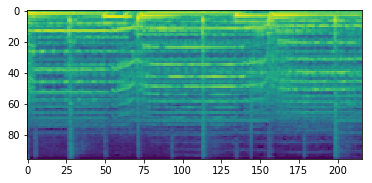

Tracks most similar to Portishead - Glory Box [0.45] : https://p.scdn.co/mp3-preview/1022495d4f4210e2dca85844375715ca286aa0df?cid=194086cb37be48ebb45b9ba4ce4c5936


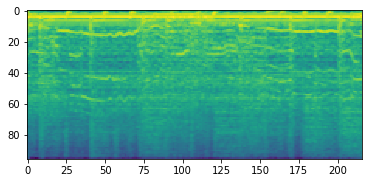

3uD0MyPsS8HsWfzyw0EAQ3 : Yo La Tengo - Sugarcube [0.46] : https://p.scdn.co/mp3-preview/85dde727deda16b2e2060c3ead0e159926514ce5?cid=194086cb37be48ebb45b9ba4ce4c5936


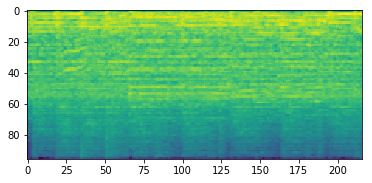

6FlgXdr8JJLfQvMoHQjE0r : Destroyer - Hey, Snow White [0.36] : https://p.scdn.co/mp3-preview/bb664bf7865d0478676eddc065426c8e99abb255?cid=194086cb37be48ebb45b9ba4ce4c5936


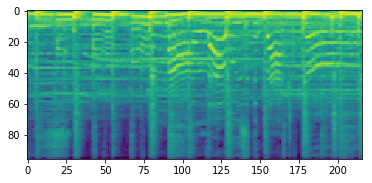

6sIvnxXHXG2evHPVFk44Dt : Hospitality - Going Out [0.43] : https://p.scdn.co/mp3-preview/7a9219607f1f596d324b4ed1d16d3ca59ec4fab5?cid=194086cb37be48ebb45b9ba4ce4c5936



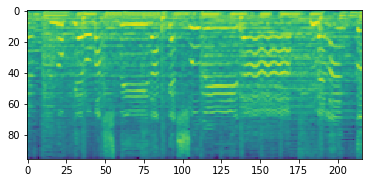

Tracks most similar to Camilo Sesto - Vivir Así Es Morir de Amor [0.87] : https://p.scdn.co/mp3-preview/9d731886399ba8411787d98b56f93a21c216bae6?cid=194086cb37be48ebb45b9ba4ce4c5936
40TDHz700L8QWiBy4cv3eB : Nana Mouskouri - Se Que Volveras [0.93] : 


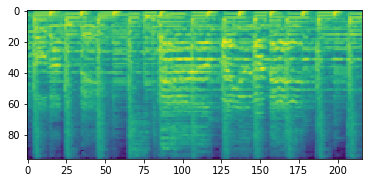

6M1y1gCywRIiHBxXzIweR4 : Tony Ronald - Help, Get Me Some Help [0.92] : https://p.scdn.co/mp3-preview/5099d322e255aa9917d6b7dfd4f66b981a0d2930?cid=194086cb37be48ebb45b9ba4ce4c5936
1ruly3JzgDE8aN3Y01ZZuv : Nat King Cole - Ansiedad [0.89] : 



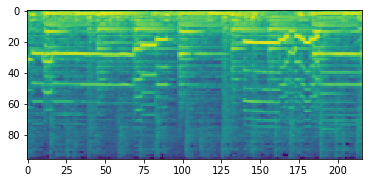

Tracks most similar to John Coltrane - My Favorite Things [0.81] : https://p.scdn.co/mp3-preview/2c2de30a01ea2e1d040bd219ee2436208163f7c5?cid=194086cb37be48ebb45b9ba4ce4c5936


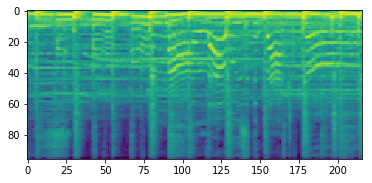

6sIvnxXHXG2evHPVFk44Dt : Hospitality - Going Out [0.87] : https://p.scdn.co/mp3-preview/7a9219607f1f596d324b4ed1d16d3ca59ec4fab5?cid=194086cb37be48ebb45b9ba4ce4c5936
30iJ65cgv0xm9mnLt8yhsu : Father John Misty - So I'm Growing Old on Magic Mountain [0.81] : 


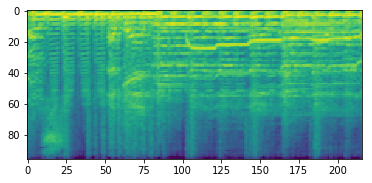

57OOcoJTdkGoKUpz4L3mWW : Damaged Bug - Gloves for Garbage [0.84] : https://p.scdn.co/mp3-preview/55ef6ff7ba87e249cca2942461d0fd1b5664668e?cid=194086cb37be48ebb45b9ba4ce4c5936



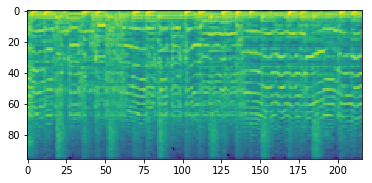

Tracks most similar to Queen - Don't Stop Me Now - Remastered [0.23] : https://p.scdn.co/mp3-preview/5fda76b980c7de5df1e7e9b2d54464665b6029ce?cid=194086cb37be48ebb45b9ba4ce4c5936


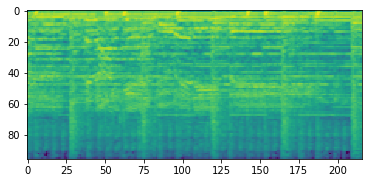

4ROLwc00PqzRFLwQEPF54S : R.E.M. - Superman - 2011 - Remaster [0.20] : https://p.scdn.co/mp3-preview/36a0f56e8babfbbccb3d2a40ab6933295b957fda?cid=194086cb37be48ebb45b9ba4ce4c5936


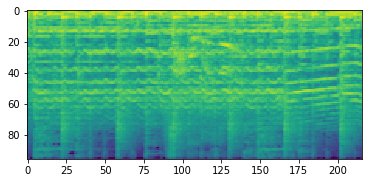

42P2bJSBsKAiwTRoQePTz3 : Billy Idol - Cradle Of Love - Remastered [0.19] : https://p.scdn.co/mp3-preview/f02b825df49a6bad38a2419699e95a75098f9e04?cid=194086cb37be48ebb45b9ba4ce4c5936
1VZUdU9Yb9fd9xRMnUCSXG : The Rolling Stones - Ruby Tuesday [0.22] : 



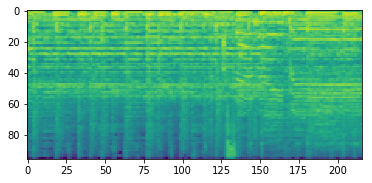

Tracks most similar to Oasis - Wonderwall [0.11] : https://p.scdn.co/mp3-preview/48a875fc1117e0c027571813c3c65b7c4fe52cfa?cid=194086cb37be48ebb45b9ba4ce4c5936


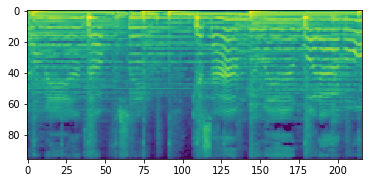

1b0QKU3QxqpWDsrdvTuvpM : Jason Isbell - Something More Than Free [0.00] : https://p.scdn.co/mp3-preview/7356fa4521eaf54ef7720c74fa54adcc457ce542?cid=194086cb37be48ebb45b9ba4ce4c5936


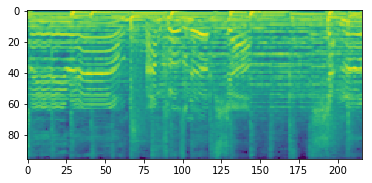

4RYksZuX2OOLjcPJdYkgSU : Toby Keith - A Little Too Late [0.05] : https://p.scdn.co/mp3-preview/a47e1963dc34ad36a4dd1ef1cb90a8e16220f42b?cid=194086cb37be48ebb45b9ba4ce4c5936
51JJuDBT4n2bgVasYgkBjD : Jason Isbell - Live Oak [0.03] : 



In [11]:
model.load_weights(checkpoint_dir + 'speccy')
test_model(True)

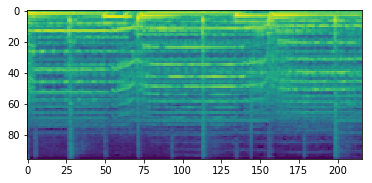

Tracks most similar to Portishead - Glory Box : https://p.scdn.co/mp3-preview/1022495d4f4210e2dca85844375715ca286aa0df?cid=194086cb37be48ebb45b9ba4ce4c5936


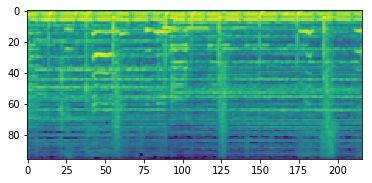

2sW8fmnISifQTRgnRrQTYW : Portishead - Roads [0.93 vs 0.84] : https://p.scdn.co/mp3-preview/8dffc8157998ff1ec4605680825edc84f796f085?cid=194086cb37be48ebb45b9ba4ce4c5936


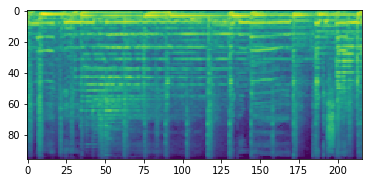

6vTtCOimcPs5H1Jr9d0Aep : Portishead - Sour Times [0.95 vs 0.82] : https://p.scdn.co/mp3-preview/525771a52de05df838477fea6a9d9b2662d41ae9?cid=194086cb37be48ebb45b9ba4ce4c5936


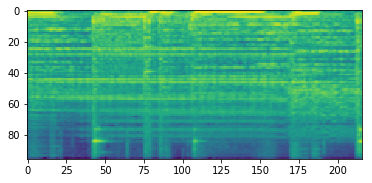

785Qya5mtMUwBQtuypVqrx : Portishead - All Mine [0.96 vs 0.72] : https://p.scdn.co/mp3-preview/70ae4b5fa84a05db3da08f65eda81823b495f573?cid=194086cb37be48ebb45b9ba4ce4c5936


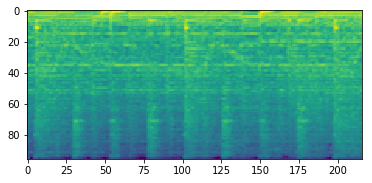

7uv632EkfwYhXoqf8rhYrg : Massive Attack - Angel [0.93 vs 0.71] : https://p.scdn.co/mp3-preview/d8d069e27fd103a2fbb34fe9932dcbba686e31e1?cid=194086cb37be48ebb45b9ba4ce4c5936

Tracks most unlike Portishead - Glory Box : https://p.scdn.co/mp3-preview/1022495d4f4210e2dca85844375715ca286aa0df?cid=194086cb37be48ebb45b9ba4ce4c5936


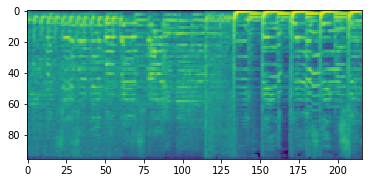

66hhxEaej22ngiSB1XUOth : Johny Cola - Prinsserne Fra Blokken [0.07 vs 0.37] : https://p.scdn.co/mp3-preview/bd3292a8fcab094ade90ce6d15dd53c96728b712?cid=194086cb37be48ebb45b9ba4ce4c5936


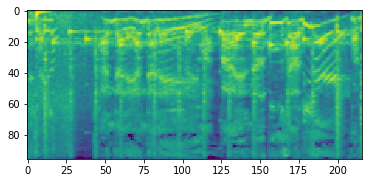

6sMvVlFRSns1Ajh3TZlDOM : Henrik Blomme - Andale [0.23 vs 0.34] : https://p.scdn.co/mp3-preview/e3253e4625dcd18919afba57fba2c17ab19da73d?cid=194086cb37be48ebb45b9ba4ce4c5936


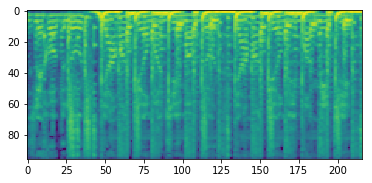

0oepFnkvjAE5xKZ0oz7MWI : Ome Omar - Jamanbroer [0.29 vs 0.33] : https://p.scdn.co/mp3-preview/f4287bd7a9b17406328415667c2f94e08a1e25d3?cid=194086cb37be48ebb45b9ba4ce4c5936


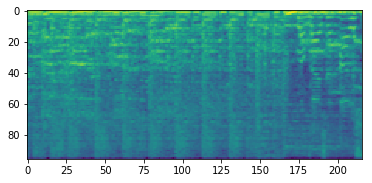

2MYkWtF9eRmuXuYFvnrQft : Jebroer - Wij Zijn Alles - Rät N FrikK Remix [0.26 vs 0.33] : https://p.scdn.co/mp3-preview/785ee77d9bfaace04bf1659acc65973a757b05f1?cid=194086cb37be48ebb45b9ba4ce4c5936


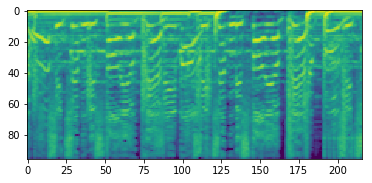

5tDm60H1Vy450EVe41jBUT : BFL - Stadig Brian [0.31 vs 0.33] : https://p.scdn.co/mp3-preview/723c32060e11b94203ab94a0af5cd59316d8e9e1?cid=194086cb37be48ebb45b9ba4ce4c5936



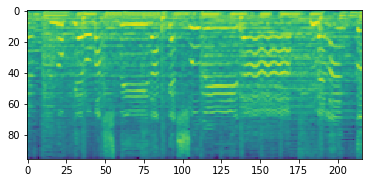

Tracks most similar to Camilo Sesto - Vivir Así Es Morir de Amor : https://p.scdn.co/mp3-preview/9d731886399ba8411787d98b56f93a21c216bae6?cid=194086cb37be48ebb45b9ba4ce4c5936


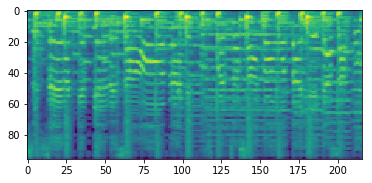

59ZWNHCFaMoM1wOTlZ0E0k : Raffaella Carrà - Caliente, Caliente [0.90 vs 0.97] : https://p.scdn.co/mp3-preview/3ff58e5f3b27769684a4528153495cf2ceb34d55?cid=194086cb37be48ebb45b9ba4ce4c5936


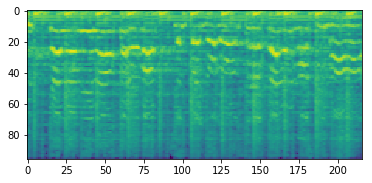

2rHhKu1hW8uqyr7LSrRn8E : Azucar Moreno - Bandido [0.77 vs 0.96] : https://p.scdn.co/mp3-preview/628fd290fd03a9ef618114f7ab0d30882369a9d4?cid=194086cb37be48ebb45b9ba4ce4c5936


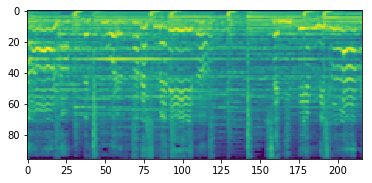

1gNXYvLc14OmqK6gSJKLUM : Rocío Jurado - Como una Ola [0.83 vs 0.96] : https://p.scdn.co/mp3-preview/3bee855dca2ad63e97de32f0863cc6ccb9f8e27b?cid=194086cb37be48ebb45b9ba4ce4c5936

Tracks most unlike Camilo Sesto - Vivir Así Es Morir de Amor : https://p.scdn.co/mp3-preview/9d731886399ba8411787d98b56f93a21c216bae6?cid=194086cb37be48ebb45b9ba4ce4c5936


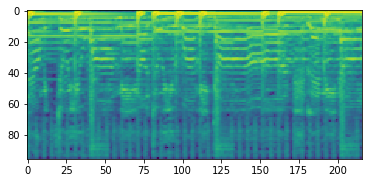

3S1dS2cFNidOa2kfcDR8hd : Bazanji - What You Want [0.39 vs 0.46] : https://p.scdn.co/mp3-preview/be08b5530d68d4261b2556b7188bd8ac6236aebe?cid=194086cb37be48ebb45b9ba4ce4c5936


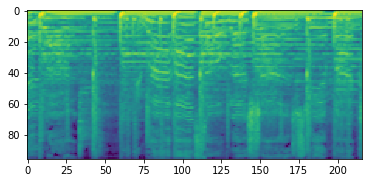

4krw2gEus4YJu5wlzUdhth : Marty Grimes - The Weekend (feat. Meta4) [0.34 vs 0.45] : https://p.scdn.co/mp3-preview/d62c9730d15dd2bcd04c69217436388a84feb386?cid=194086cb37be48ebb45b9ba4ce4c5936


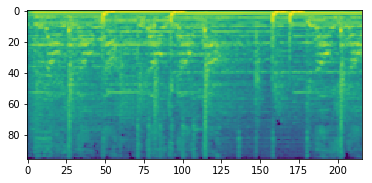

62odlyTMyNberee7V1AmfT : Justin Stone - You Don't Know [0.41 vs 0.45] : https://p.scdn.co/mp3-preview/abe14fd99ea7b88af05d1795dfc1af6c0baa7782?cid=194086cb37be48ebb45b9ba4ce4c5936



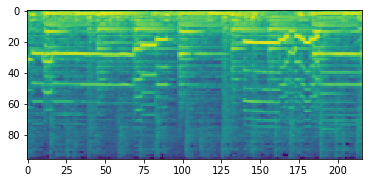

Tracks most similar to John Coltrane - My Favorite Things : https://p.scdn.co/mp3-preview/2c2de30a01ea2e1d040bd219ee2436208163f7c5?cid=194086cb37be48ebb45b9ba4ce4c5936


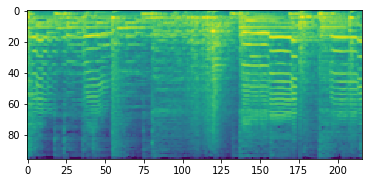

2jz7vSAguRJmBHEA4I6C4N : Wayne Shorter - Footprints [0.77 vs 0.98] : https://p.scdn.co/mp3-preview/9f29d654f9f895611fb6e4b33c2ac3128052c0eb?cid=194086cb37be48ebb45b9ba4ce4c5936


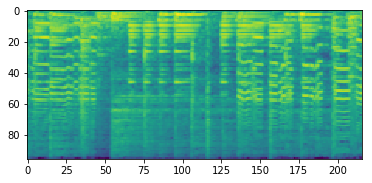

5klynmZw7TdqVsGvaxQH57 : Horace Silver - Song For My Father [0.69 vs 0.97] : https://p.scdn.co/mp3-preview/e902d47edd3fc7a1dcca3f1e9a5395c75b54af92?cid=194086cb37be48ebb45b9ba4ce4c5936

Tracks most unlike John Coltrane - My Favorite Things : https://p.scdn.co/mp3-preview/2c2de30a01ea2e1d040bd219ee2436208163f7c5?cid=194086cb37be48ebb45b9ba4ce4c5936


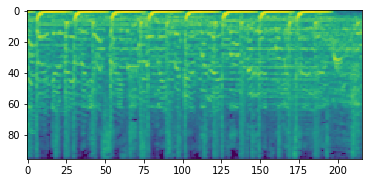

7mhBUc1GeEQPU6AeFTwzZe : Maxwell D - I Got The Love (feat. Stella Mwangi & Janice Meyers) [0.19 vs 0.36] : https://p.scdn.co/mp3-preview/ce8fbc10410070cac886dae802e57345fb561bea?cid=194086cb37be48ebb45b9ba4ce4c5936


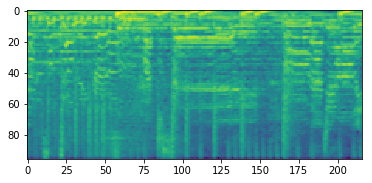

5MrmQLN8g4BgdbavepVEbq : OJ Da Juiceman - OOH What U Say [0.26 vs 0.35] : https://p.scdn.co/mp3-preview/66a171bfa230b2fd1698dd8406bb61c12c8c89b6?cid=194086cb37be48ebb45b9ba4ce4c5936


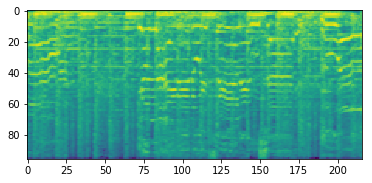

2069hfA3TrpjAP2epyfc8s : David Correy - The World Is Ours (feat. Aloe Blacc) [0.20 vs 0.33] : https://p.scdn.co/mp3-preview/a947f5788a830ca687c478088823e1c9b6f3cd44?cid=194086cb37be48ebb45b9ba4ce4c5936



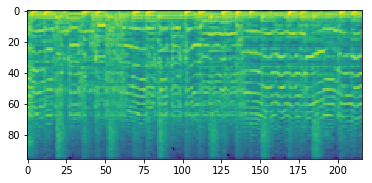

Tracks most similar to Queen - Don't Stop Me Now - Remastered : https://p.scdn.co/mp3-preview/5fda76b980c7de5df1e7e9b2d54464665b6029ce?cid=194086cb37be48ebb45b9ba4ce4c5936


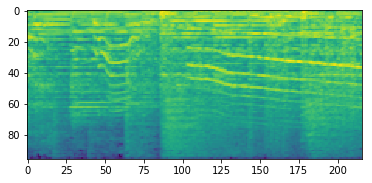

2fuCquhmrzHpu5xcA1ci9x : Queen - Under Pressure - Remastered [0.93 vs 0.82] : https://p.scdn.co/mp3-preview/b329081abca56123f894650065adb85b29b372af?cid=194086cb37be48ebb45b9ba4ce4c5936


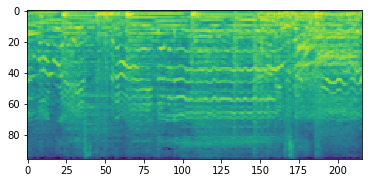

1lCRw5FEZ1gPDNPzy1K4zW : Queen - We Are The Champions - Remastered 2011 [0.93 vs 0.82] : https://p.scdn.co/mp3-preview/6a8fbda81a219fc7f49fc4a4ecc1d027934b66e5?cid=194086cb37be48ebb45b9ba4ce4c5936


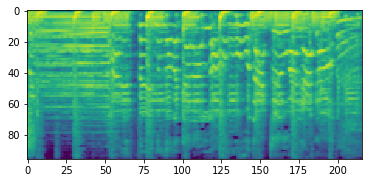

5vdp5UmvTsnMEMESIF2Ym7 : Queen - Another One Bites The Dust - Remastered 2011 [0.95 vs 0.81] : https://p.scdn.co/mp3-preview/c105fe344eed632ebb72a1a0ed8efcfb5a47c6ff?cid=194086cb37be48ebb45b9ba4ce4c5936

Tracks most unlike Queen - Don't Stop Me Now - Remastered : https://p.scdn.co/mp3-preview/5fda76b980c7de5df1e7e9b2d54464665b6029ce?cid=194086cb37be48ebb45b9ba4ce4c5936


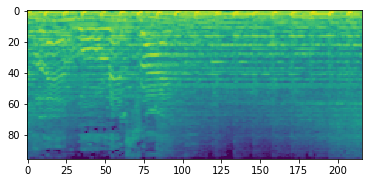

6Xmcw141LKERzrhLJuXVLu : Ghost Ship - Where Were You [0.81 vs 0.14] : https://p.scdn.co/mp3-preview/cb09afa38879c3107596005afe7c022a7883aeb8?cid=194086cb37be48ebb45b9ba4ce4c5936


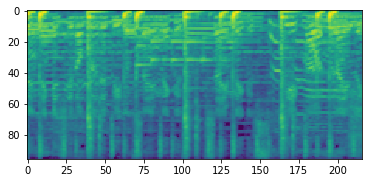

1XW4sFE94iHH9KKlFEpCp0 : Mase - Same Niggas [0.49 vs 0.13] : https://p.scdn.co/mp3-preview/f7fcff7a8fe08a9b1af55974030ace55ebb59d44?cid=194086cb37be48ebb45b9ba4ce4c5936



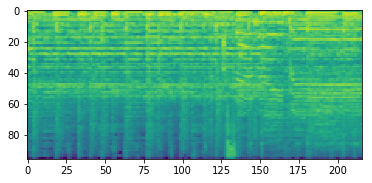

Tracks most similar to Oasis - Wonderwall : https://p.scdn.co/mp3-preview/48a875fc1117e0c027571813c3c65b7c4fe52cfa?cid=194086cb37be48ebb45b9ba4ce4c5936


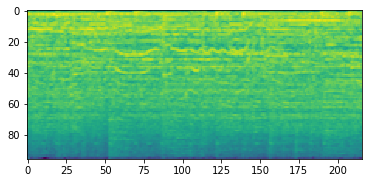

2UjLzxf4oYjHOVOBoVojlL : Oasis - Champagne Supernova [0.85 vs 0.72] : https://p.scdn.co/mp3-preview/14d0af99bf37887f49ab53ded6175ad12787d910?cid=194086cb37be48ebb45b9ba4ce4c5936


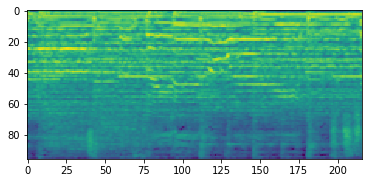

2PuakTXE2v2j2F86V92ZvD : Oasis - Stop Crying Your Heart Out [0.88 vs 0.70] : https://p.scdn.co/mp3-preview/95c4487b84af7d9fbf78df04b2c480a9f5e5bb11?cid=194086cb37be48ebb45b9ba4ce4c5936


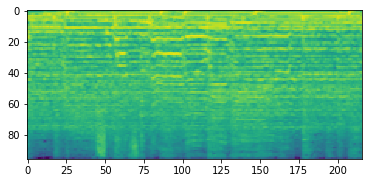

1kBzKgtm127gi8eSBpZEp1 : Oasis - Stand By Me [0.83 vs 0.66] : https://p.scdn.co/mp3-preview/e4e4f99829fe48bfff47449c93de20ab0e30ad3e?cid=194086cb37be48ebb45b9ba4ce4c5936

Tracks most unlike Oasis - Wonderwall : https://p.scdn.co/mp3-preview/48a875fc1117e0c027571813c3c65b7c4fe52cfa?cid=194086cb37be48ebb45b9ba4ce4c5936


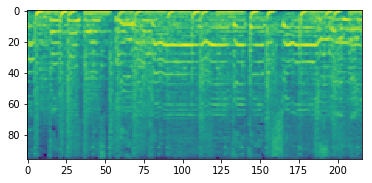

2KQftUXRA91WigM16D5aMd : THE RAMPAGE from EXILE TRIBE - FRONTIERS [0.56 vs 0.26] : https://p.scdn.co/mp3-preview/5b7ce35915075e79be6b8073f6f8e234f3723cd1?cid=194086cb37be48ebb45b9ba4ce4c5936


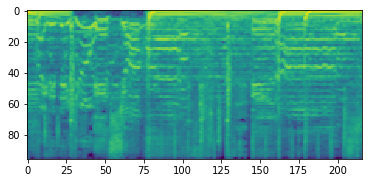

7j4YVmV8BYGFn4nNmyMzfZ : The Sound - Great Are You Lord (Howland Mix) [0.55 vs 0.25] : https://p.scdn.co/mp3-preview/0093ecbbe074598bedc31ad4a23a611928fb62bc?cid=194086cb37be48ebb45b9ba4ce4c5936


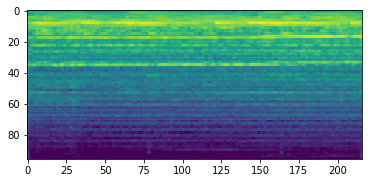

5fHgBb5r91Jmdr8Q7dwmad : Jeremy Soule - Secunda [0.72 vs 0.24] : https://p.scdn.co/mp3-preview/466883e78eaab2224e789c823115957f415629bc?cid=194086cb37be48ebb45b9ba4ce4c5936


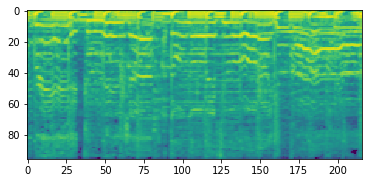

2krIybpejbIKwVB3xNmYU2 : Nick & Sammy - O.o.O(On or Off)(English ver.) [0.56 vs 0.24] : https://p.scdn.co/mp3-preview/0b0757591cbf4dd844c9f8a32093a1d961165fbc?cid=194086cb37be48ebb45b9ba4ce4c5936



In [12]:
test_model2(True)

### Baseline model

In [17]:
# find vector in embedding which is (cosine) closest to all the others
# if our model is to be any good, it should at least beat this loss

input_shape = (embedding_norm.shape[1],)
model_input = Input(input_shape, name='input')
layer = model_input
layer = Dense(embedding_norm.shape[1])(layer)
model_output = layer
baseline_model = Model(model_input, model_output)
baseline_model.compile(loss="cosine_proximity", optimizer="adam")

def baseline_generator(batch_size = 64):
    indices = np.random.permutation(embedding_norm.shape[0])
    i = 0
    while True:
        start = i * batch_size
        end = start + batch_size
        batch = indices[start:end]
        # always feed in same inputs
        batch_X = np.array([np.ones(embedding_norm.shape[1]) for j in batch])
        batch_Y = np.array([embedding_norm[j] for j in batch])
        i = i + 1
        if end >= embedding_norm.shape[0]:
            i = 0
        yield(batch_X, batch_Y)
        
baseline_model.fit_generator(baseline_generator(batch_size=128),
                             steps_per_epoch=10000,
                             epochs=1)

x = np.random.rand(1, embedding_norm.shape[1])
y_pred = baseline_model.predict(x)
most_similar = embedding_model.wv.similar_by_vector(np.squeeze(y_pred, axis=0), topn=1)
print(f'{most_similar[0][0]} : {tracks[most_similar[0][0]][0]} : {tracks[most_similar[0][0]][1]}')

Epoch 1/1
10000/10000 [==============================] - 23s 2ms/step - loss: -0.5275
6wWjiM0dGME9srg7xRH98A : SBTRKT - Sanctuary : https://p.scdn.co/mp3-preview/5ac546c1bcbb1d0a6dbeced979dc95361ffc2530?cid=194086cb37be48ebb45b9ba4ce4c5936
